In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np

# mlflow imports
from mlflow.models.signature import infer_signature

# sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs
import oma_tracking.models.mlflow_functions as mlflow_f


from dotenv import load_dotenv
load_dotenv()

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


True

In [3]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2c02'
name_location = 'NW2_C02'

home_folder = "../../../"
# Data Paths
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = home_folder + "data/nw2/raw/" + data_file_name + ".parquet"
mvbc_path = home_folder + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = home_folder + "data/nw2/tracked_modes/harmonics_removed/" + location + ".parquet"
simulations_data_path = home_folder + "data/nw2/simulations/" + location + "/"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
#simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
#simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
#simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [4]:
AZURE_STORAGE_ACCESS_KEY = os.getenv('AZURE_STORAGE_ACCESS_KEY')
AZURE_STORAGE_CONNECTION_STRING = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

artifact_root = 'wasbs://test@mlflowstoragev1.blob.core.windows.net'
mlflow_ui_string = mlflow_f.create_mlflow_ui(MLFLOW_TRACKING_URI, artifact_root)
database_url = 'http://127.0.0.1:5000'
mlflow_f.connect_mlflow_ui(mlflow_ui_string, database_url)

experiment_name = 'NW2_scour'
experiment = mlflow_f.run_mlflow_experiment(experiment_name = experiment_name)

c:\users\max\documents\owi_lab\code\packages\oma_tracking\oma_tracking\models\mlflow_functions.py:124: UserWarning: Mlflow_tracking_uri passed without checking checking username for ':' and '@' symbols. Manually control the uri!
  warnings.warn(


mlflow experiment set to: NW2_scour


mlflow sear queries:
tags.location_id = 'D01' and parameters.prediction_parameter= 'FA2'

In [21]:
weather_inputs = make_dataset.get_weather_subset(mvbc_data)
scada_inputs = make_dataset.get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

In [ ]:
inputs

2023/04/03 17:10:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/04/03 17:10:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/04/03 17:10:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/03 17:10:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/04/03 17:11:11 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-02-28; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'oma-tracking'}
2023/04/03 17:12:33 WARNING mlflow.utils.autologg

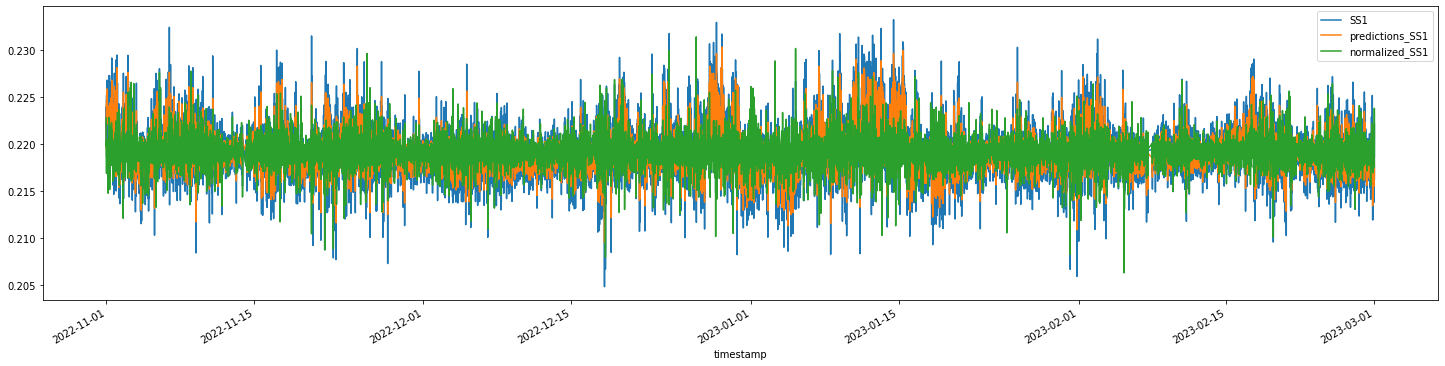

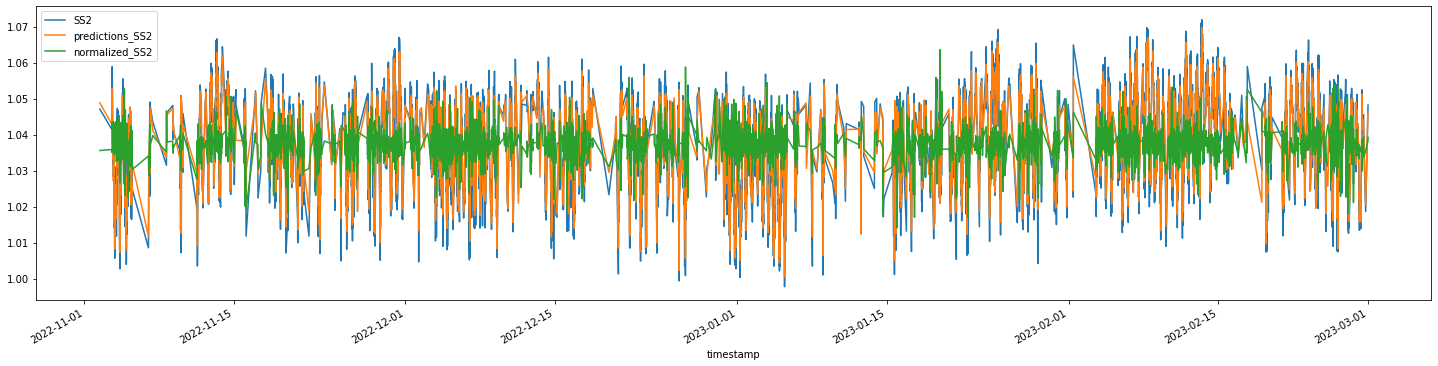

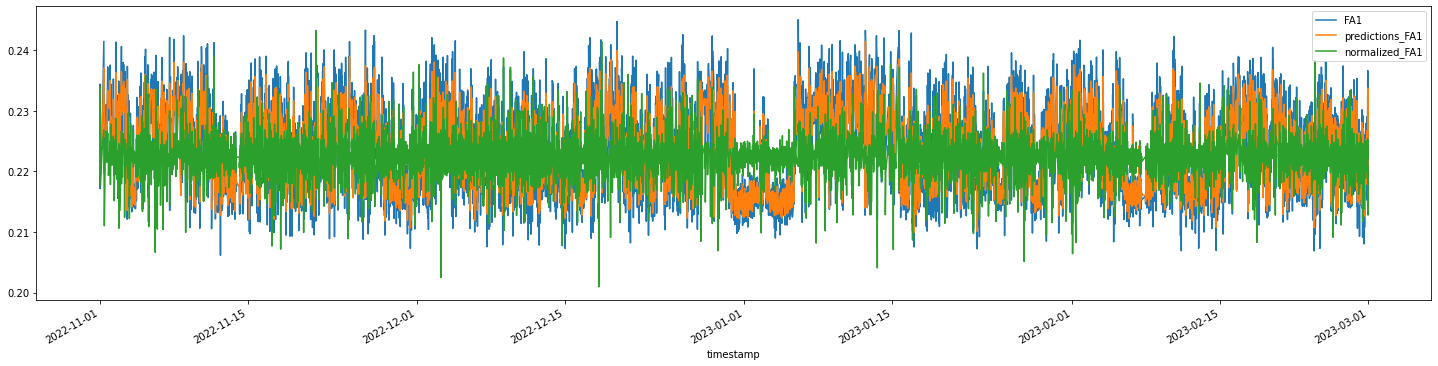

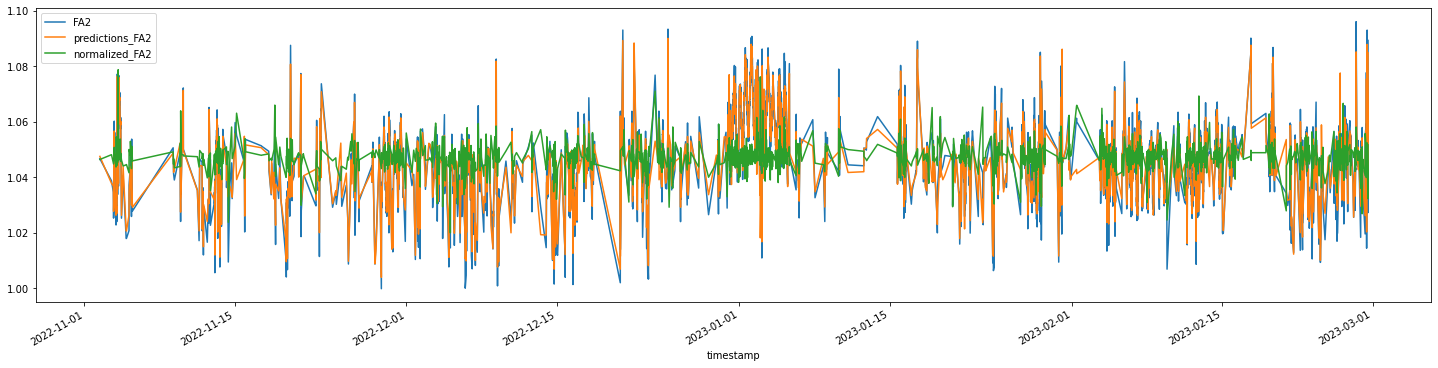

In [23]:
## Track Models in MLFlow
# Randomforestregressor
test_size = 0.2
random_state = 42
nb_path = os.getcwd()

site = 'NorthWester2'
site_id = 'NW2'
location_id = 'D01'
structure =  'OWT'
type = 'MPE'
model_function = 'normalization'
tags = {
        "site_id": str(site_id),
        "location_id": str(location_id),
        "structure": str(structure),
        "type": str(type)
    }

run_name = \
    '_'.join(
        [
            name_location,
            type,
            model_function,
            datetime.datetime.today().strftime('%Y-%m-%d')
        ]
    )

predictions_inv = pd.DataFrame()
models = {}

for mode in prediction_params.columns:
    with mlflow.start_run(tags=tags, run_name=run_name):
        
        
        mlflow.autolog(log_models=True, exclusive=False)
        y = prediction_params[mode].dropna()
        X = inputs.loc[y.index].dropna()
        y = y.loc[X.index]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        regr = Pipeline(
            steps=[
                ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                ('regressor', RandomForestRegressor())
                ]
            )
        regr.fit(X_train, y_train)

        models[mode] = regr

        metrics = mlflow.sklearn.eval_and_log_metrics(
                regr, X_test, y_test, prefix="test_"
            )
        
        params = {
                "model function": 'normalization',
                "prediction_parameter": str(mode),
                "time_period": str(start) + ' - ' + str(stop),
                "data_random_state": random_state,
                "test_size": test_size,
                "notebook": nb_path,
                "model": str(regr),
                "data selection": "harmonics removed"
            }
        
        mlflow.log_params(params)
        predictions_mode = pd.DataFrame(
            {'predictions_'+str(mode): regr.predict(X),
            'normalized_'+str(mode): y - regr.predict(X) + np.mean(y)}, index = y.index)
        
        predictions_inv = pd.concat([predictions_inv, predictions_mode], axis = 1)
        pd.concat([y,predictions_mode], axis=1).plot(figsize=(25,6))

        signature = infer_signature(X_test, regr.predict(X_test))
        mlflow.autolog(disable=True)
        mlflow.end_run()

2023/04/03 17:15:37 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/04/03 17:15:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/04/03 17:15:37 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/03 17:15:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/04/03 17:15:37 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessing_angles', AngleTransformer(angles=['winddirection', 'yaw'])), ('regressor', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample

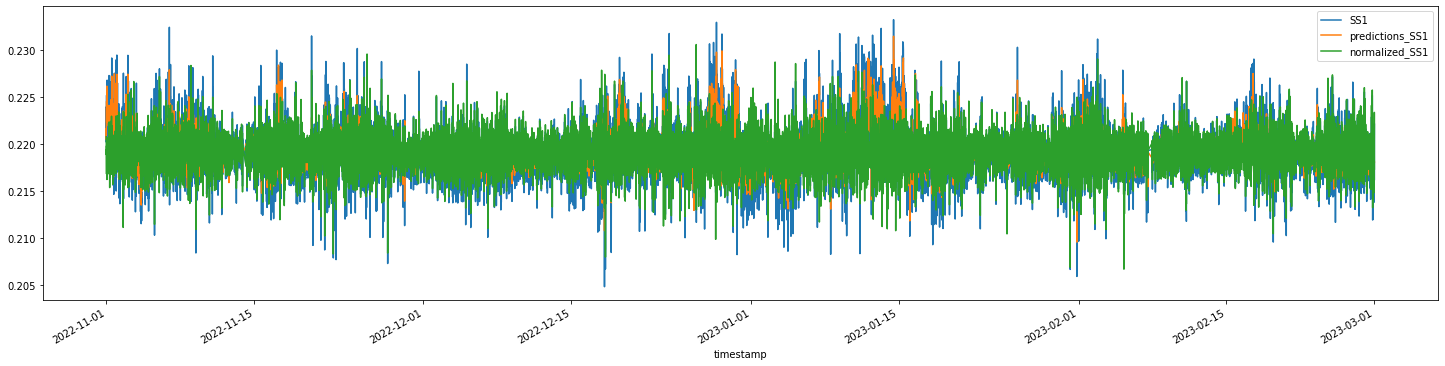

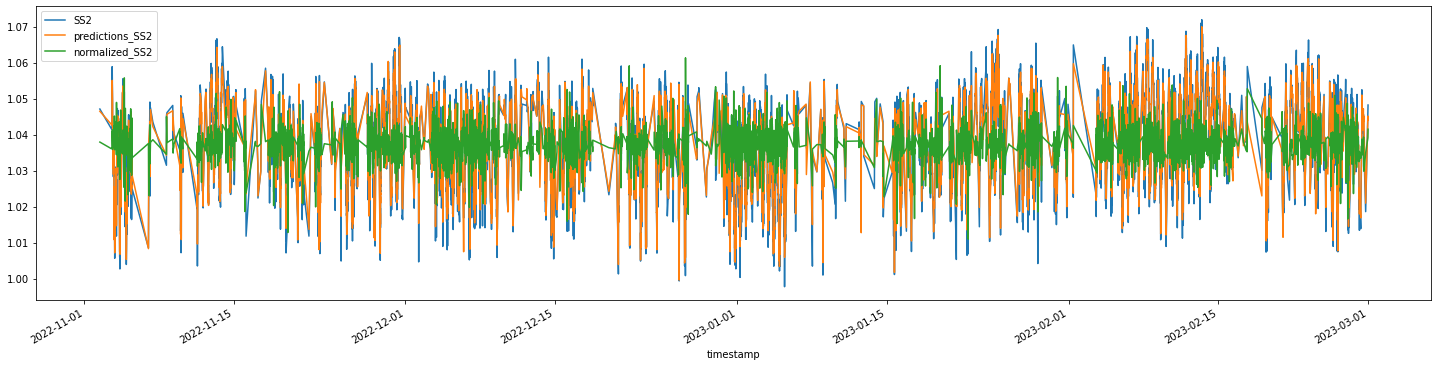

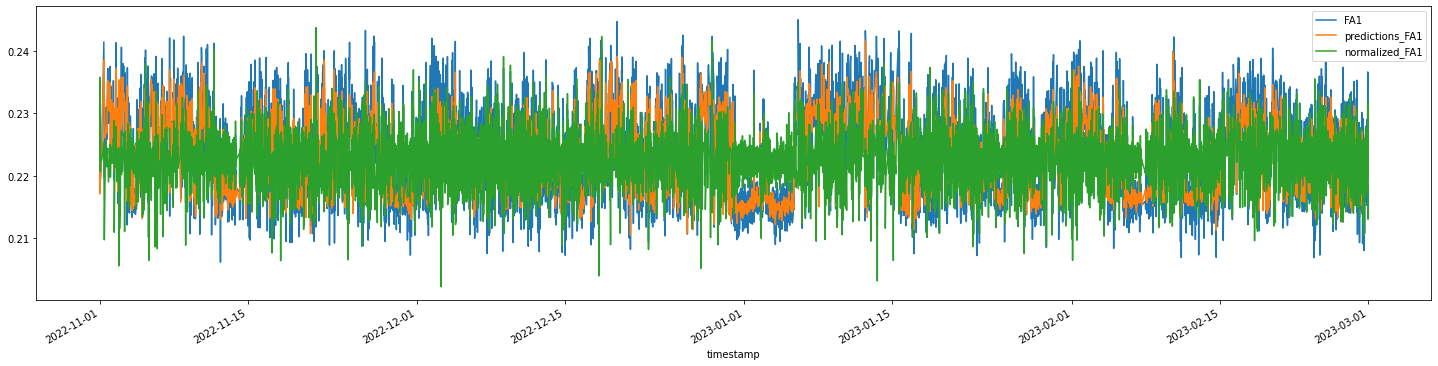

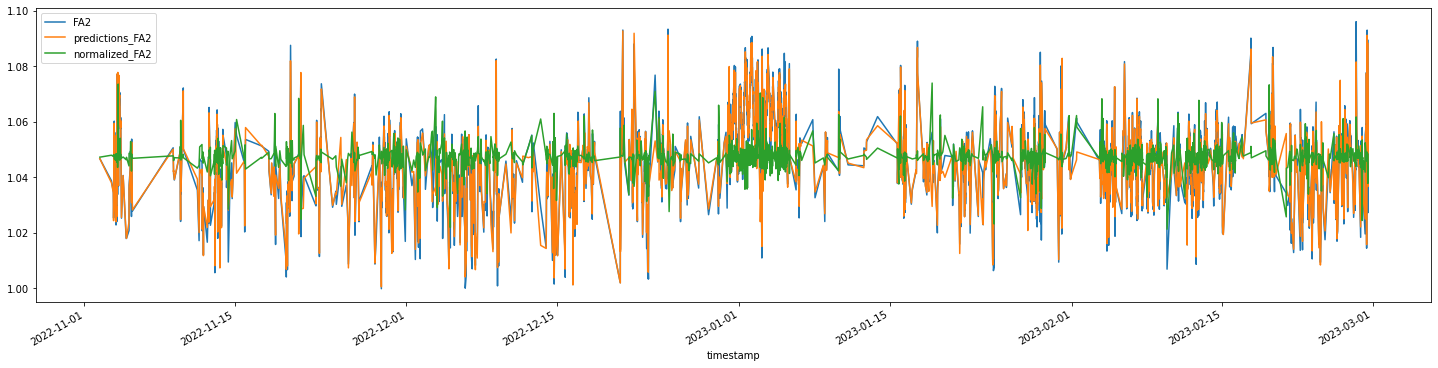

In [24]:
from xgboost import XGBRegressor

# Track Models in MLFlow
test_size = 0.2
random_state = 42
nb_path = os.getcwd()

site = 'NorthWester2'
site_id = 'NW2'
location_id = 'D01'
structure =  'OWT'
type = 'MPE'
model_function = 'normalization'
tags = {
        "site_id": str(site_id),
        "location_id": str(location_id),
        "structure": str(structure),
        "type": str(type)
    }

run_name = \
    '_'.join(
        [
            name_location,
            type,
            model_function,
            datetime.datetime.today().strftime('%Y-%m-%d')
        ]
    )

predictions_inv = pd.DataFrame()
models = {}

for mode in prediction_params.columns:
    with mlflow.start_run(tags=tags, run_name=run_name):
        
        mlflow.autolog(log_models=True, exclusive=False)
        y = prediction_params[mode].dropna()
        X = inputs.loc[y.index].dropna()
        y = y.loc[X.index]
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        regr = Pipeline(
            steps=[
                ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                ('regressor', XGBRegressor())
                ]
            )
        regr.fit(X_train, y_train)

        models[mode] = regr

        metrics = mlflow.sklearn.eval_and_log_metrics(
                regr, X_test, y_test, prefix="test_"
            )
        
        params = {
                "model function": 'normalization',
                "prediction_parameter": str(mode),
                "time_period": str(start) + ' - ' + str(stop),
                "data_random_state": random_state,
                "test_size": test_size,
                "notebook": nb_path,
                "model": str(XGBRegressor),
                "data selection": "harmonics removed"
            }
        
        mlflow.log_params(params)
        predictions_mode = pd.DataFrame(
            {
                'predictions_'+str(mode): regr.predict(X),
                'normalized_'+str(mode): y - regr.predict(X) + np.mean(y)
            },
            index = y.index
        )
        
        predictions_inv = pd.concat([predictions_inv, predictions_mode], axis = 1)
        pd.concat([y,predictions_mode], axis=1).plot(figsize=(25,6))

        mlflow.autolog(disable=True)
        mlflow.end_run()

In [25]:
predictions = pd.DataFrame(index = inputs.dropna().index)
for mode in models.keys():
    predictions[mode] = models[mode].predict(inputs.dropna())
residuals = prediction_params - predictions
normalized = residuals + tracked_frequencies.mean()

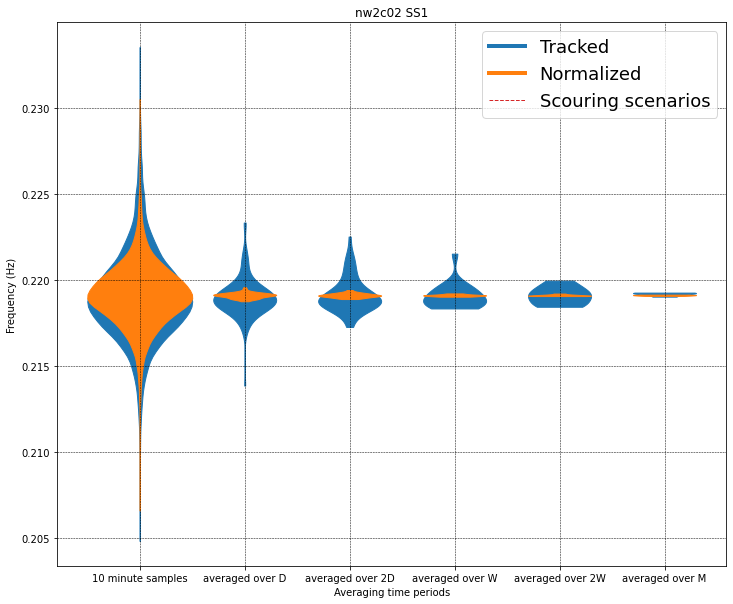

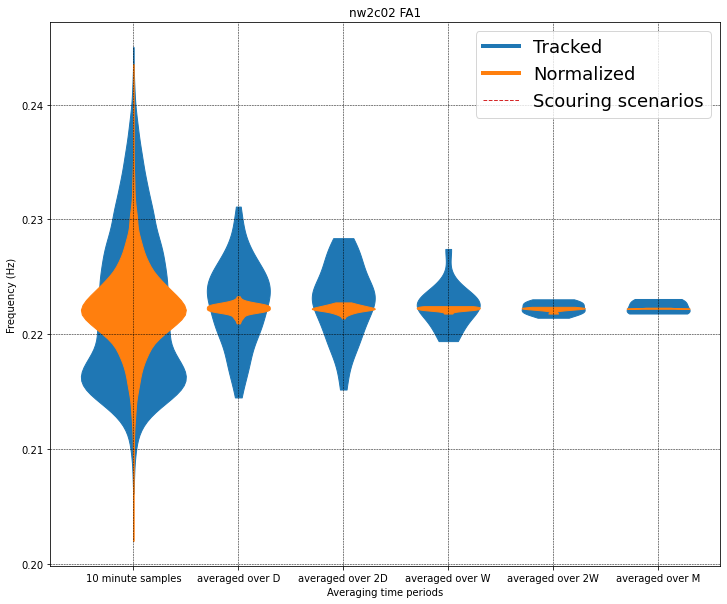

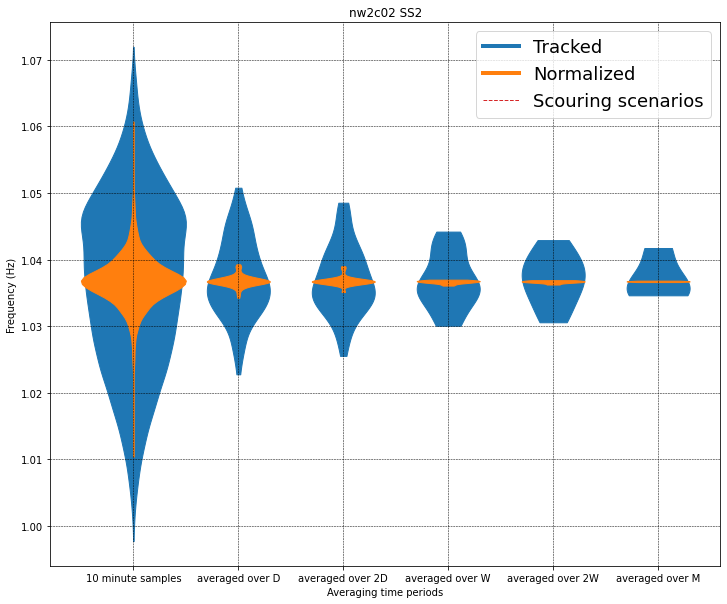

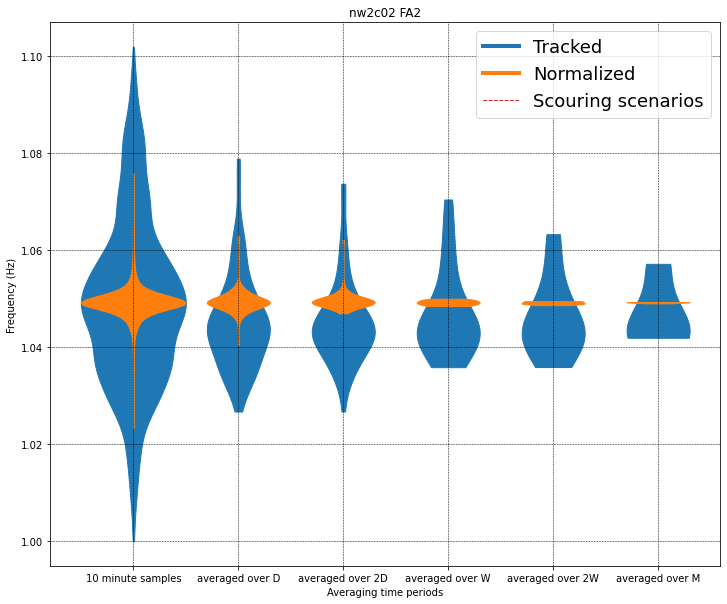

In [26]:
from matplotlib.lines import Line2D
from oma_tracking.scouring.scouring import aggregate_time_series
import matplotlib.pyplot as plt

label = 'scouring scenarios'

font_size = 18
timespans = ['D', '2D', 'W', '2W', 'M']
for mode in ['SS1', 'FA1', 'SS2', 'FA2']:
    fig, ax = plt.subplots(figsize=(12, 10))
    i = 1
    x_keys = []
    vps = plt.violinplot(tracked_frequencies[mode].dropna(), positions=[i], widths=1.0, showextrema=False)
    for vp in vps['bodies']:
        vp.set_facecolor('tab:blue')
        vp.set_color('tab:blue')
        vp.set_alpha(1)
    vps = plt.violinplot(normalized[mode].dropna(), positions=[i], widths=1.0, showextrema=False)
    for vp in vps['bodies']:
        vp.set_facecolor('tab:orange')
        vp.set_color('tab:orange')
        vp.set_alpha(1)
    
    x_keys.append('10 minute samples')
    i += 1
    for timespan in timespans:
        timely_tracked_frequencies = aggregate_time_series(tracked_frequencies, timespan).dropna()
        timely_normalized_frequencies = aggregate_time_series(normalized, timespan).dropna()
        vps = plt.violinplot(timely_tracked_frequencies[mode], positions=[i], widths=0.6, showextrema=False)
        for vp in vps['bodies']:
            vp.set_facecolor('tab:blue')
            vp.set_color('tab:blue')
            vp.set_alpha(1)
        vps = plt.violinplot(timely_normalized_frequencies[mode], positions=[i], widths=0.6, showextrema=False)
        for vp in vps['bodies']:
            vp.set_facecolor('tab:orange')
            vp.set_color('tab:orange')
            vp.set_alpha(1)
        x_keys.append('averaged over ' + timespan)
        i += 1
    '''
    j = 0
    for value in simulation_shifts['parked_scour'][mode].values[:5]:
        shift = normalized[mode].mean() - normalized[mode].mean()*value/100
        print(shift)
        plt.axhline(shift, color='red', linestyle='--', linewidth=0.5, label = label)
        plt.text(
            0.2,
            shift,
            simulation_shifts['parked_scour']['Unnamed: 0'].values[j],
            fontsize=12
            )
        j += 1
    '''
    ax.set_xticks(range(1, len(x_keys) + 1))
    ax.set_xticklabels(x_keys, rotation=0)
    ax.set_title(location + ' ' + mode)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Averaging time periods')
    ax.grid(True, color='k', linestyle='--', linewidth=0.5)
    plt.legend(
        [Line2D([0], [0], color='tab:blue', lw=4), Line2D([0], [0], color='tab:orange', lw=4), Line2D([0], [0], color='tab:red', lw=1, linestyle='--')],
        ['Tracked', 'Normalized', 'Scouring scenarios'],
        fontsize=font_size,
        loc='upper right')
    plt.show()

In [27]:
models[mode]['regressor']

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [28]:
inputs

,mvbc_WandelaarBuoy_Wave_height,mvbc_WandelaarBuoy_Sea_water_temperature,mvbc_WandelaarMeasuringpile_Tide_TAW,mvbc_WandelaarMeasuringpile_Air_pressure,mvbc_WandelaarMeasuringpile_Air_temperature,mean_NW2_C02_rpm,mean_NW2_C02_yaw,mean_NW2_C02_pitch,mean_NW2_C02_power,mean_NW2_C02_windspeed,mean_NW2_C02_winddirection
2022-11-01 00:00:00+00:00,85.000000,15.0,106.000000,1002.800000,16.700000,10.445,162.459,10.519,9524.928,17.578,162.655
2022-11-01 00:10:00+00:00,83.666667,15.0,112.666667,1002.933333,16.700000,10.445,163.886,10.044,9524.737,17.750,165.761
2022-11-01 00:20:00+00:00,82.333333,15.0,119.333333,1003.066667,16.700000,10.445,176.979,9.932,9523.201,17.238,179.609
2022-11-01 00:30:00+00:00,81.000000,15.0,126.000000,1003.200000,16.700000,10.445,187.023,9.400,9524.224,16.852,188.897
2022-11-01 00:40:00+00:00,80.333333,15.0,134.666667,1003.333333,16.566667,10.445,193.094,12.394,9523.201,18.691,191.919
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-19 23:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-19 23:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-19 23:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-19 23:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


SS1


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


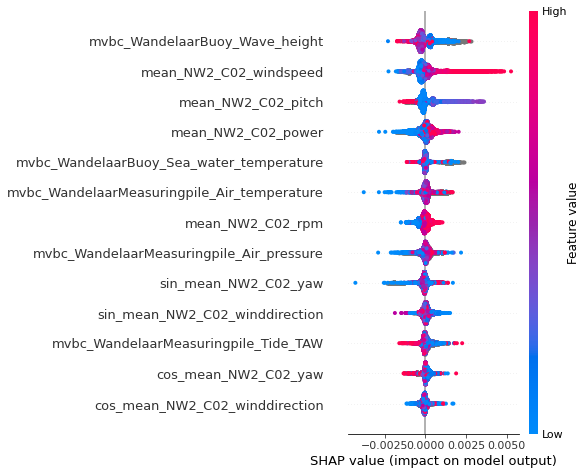

SS2


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


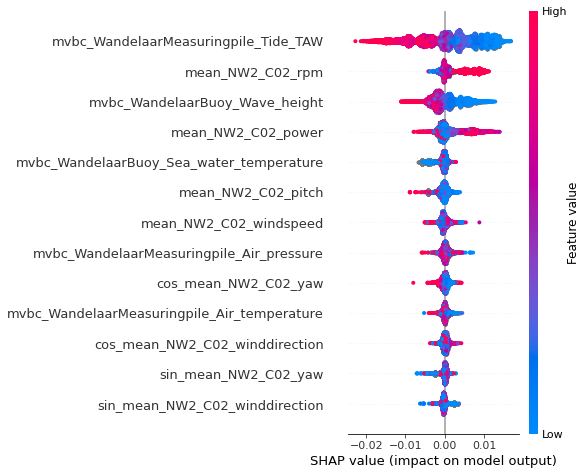

FA1


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


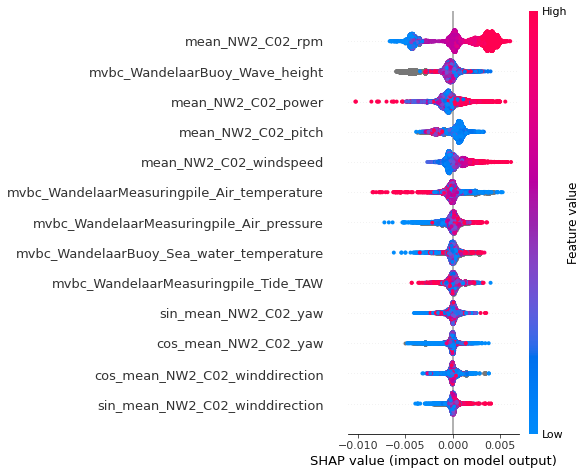

FA2


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


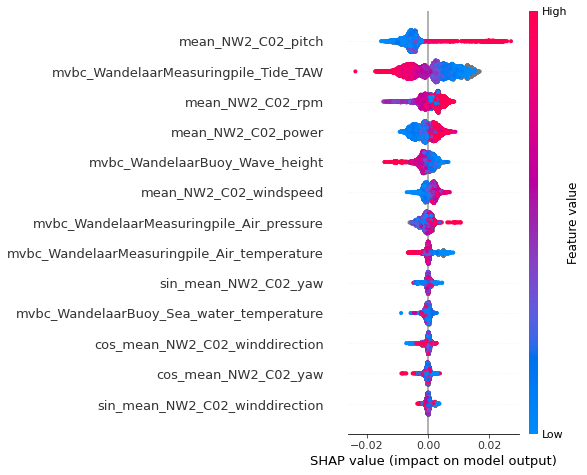

In [35]:
import mlflow
import shap

images_path = \
        '/'.join(
            [
                "C:/Users/Max/Documents/OWI_LAB/Code/Packages/oma_tracking/visualizations/",
                "nw2",
                location,
                "shap"
            ])

stage = 'Production'
for mode in tracked_frequencies.columns:
    print(mode)
    model = models[mode]['regressor']
    explainer = shap.TreeExplainer(model)
    shap_value = explainer.shap_values(models[mode]['preprocessing_angles'].transform(inputs))

    #fig_local_path = images_path + '/' + 'mpe_' + name_location + '_' + mode + '_normalization' +  '_shap_summary_plot.png'
    shap.summary_plot(shap_value, models[mode]['preprocessing_angles'].transform(inputs), show=False)

    plt.gcf().axes[-1].set_aspect('auto')
    plt.tight_layout()
    plt.gcf().axes[-1].set_box_aspect(50)
    fig = plt.gcf()
    #fig.savefig(fig_local_path)
    plt.show()
    plt.close()